## **Домашняя работа №4.**

Максимальная оценка - 10 баллов.

Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы.

В данной домашней работе требуется реализовать разбиение элементов выборки в вершине дерева.

$R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения.

Критерий ошибки:

$$
Q(R_m, j, t) = \frac{|R_\ell|}{|R_m|}H(R_\ell) + \frac{|R_r|}{|R_m|}H(R_r) \to \min_{j, t}
$$

$R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

$H(R)$ - критерий информативности, с помощью которого можно оценить качество распределения целевой переменной среди объектов множества $R$.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Iterable, List, Tuple

from sklearn.model_selection import train_test_split

In [4]:
# `load_boston` has been removed from scikit-learn since version 1.2.

#from sklearn.datasets import load_boston
#boston = load_boston()

In [5]:
#wget.download("https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/datasets/data/boston_house_prices.csv?raw=true")
data_git = pd.read_csv("https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/datasets/data/boston_house_prices.csv?raw=true",
                      skiprows = [0])
print(data_git.shape)
data_git.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


**Data Set Characteristics:**  

    :Number of Instances: 506

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.   
     
.. topic:: References

   - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.
   - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.



In [8]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [9]:
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

X = pd.DataFrame(data, columns=feature_names, index=range(len(data)))
y = pd.DataFrame(target, columns=['MEDV'], index=range(len(target)))

X['target'] = y

In [10]:
X_train, X_test= train_test_split(X, test_size=0.25, random_state=13)

**Задание 1 (2 балла)**: реализуйте подсчет критерия ошибки. Для этого реализуйте функции для подсчета значения критерия информативности, а также для разбиения вершины.

In [11]:
def H(R: np.array) -> float:
    """
    Compute impurity criterion for a fixed set of objects R.
    Last column is assumed to contain target value
    """
    N = len(R)
    target = R.iloc[:, -1]
    mu = np.mean(target)
    I = 1 / N * np.sum((target - mu) ** 2)
    return I


def split_node(R_m: np.array, feature: str, t: float) -> Iterable[np.array]:
    """
    Split a fixed set of objects R_m given feature number and threshold t
    """
    return (R_m.loc[R_m.loc[:, feature] > t], R_m.loc[R_m.loc[:, feature] <= t])


def q_error(R_m: np.array, feature: str, t: float) -> float:
    """
    Compute error criterion for given split parameters
    """
    N = len(R_m)
    R_l, R_r = split_node(R_m, feature, t)
    N_l, N_r = len(R_l), len(R_r)
    Q = N_l / N * H(R_l) + N_r / N * H(R_r)
    return Q

*Комментарий:* в функции `H(R)` считаем среднее значение целевой переменной, затем считаем качество по критерию `MSE`. В функции `split_node` просто возвращаем нужные записи. В функции `q_error` считаем ошибку по формуле выше. Здесь я работаю с параметрами как с датафреймами, а не с `numpy`-массивами, так как все данные у нас в форме датафреймов.

**Задание 2 (2 балла)**: переберите все возможные разбиения обучающей выборки по одному из признаков и постройте график критерия ошибки в зависимости от значения порога.

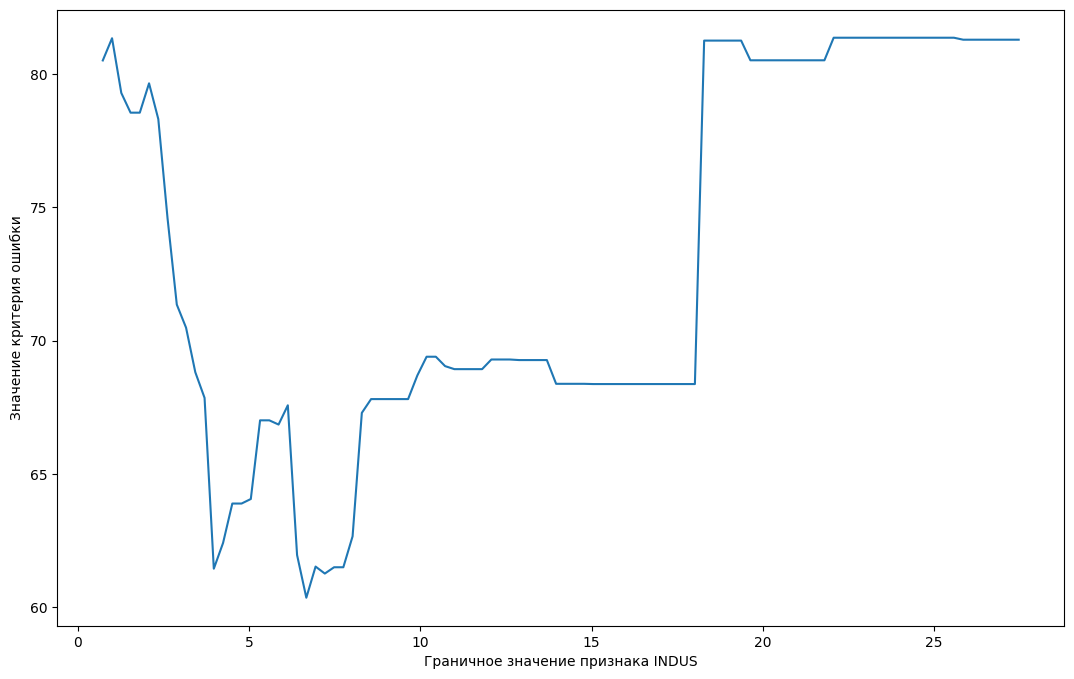

In [19]:
feature = 'INDUS'
n = 100

column = X_train.loc[:, feature]
ts = np.linspace(np.min(column), np.max(column), n+2)
ts = ts[1:-1]
Qs = [q_error(X_train, feature, ts[i]) for i in range(n)]

fig, ax = plt.subplots(figsize=(13, 8))
ax.plot(ts, Qs)
_ = ax.set_xlabel(f"Граничное значение признака {feature}")
_ = ax.set_ylabel(f"Значение критерия ошибки")

*Комментарий:* выбираем множество граничных значений таким образом, чтобы в каждое дерево попадала хотя бы одна запись и функции не ломались. На графике видим, что лучшее качество модель показывает примерно при $t=6.5$ для признака `INDUS`

**Задание 3  (2 балла)**: Напишите функцию, находящую оптимальное разбиение данной вершины по данному признаку.

In [20]:
def get_optimal_split(R_m: np.array, feature: str, n=100) -> Tuple[float,
                                                                   float,
                                                                   List[float], 
                                                                   List[float]]:
    column = R_m.loc[:, feature]
    ts = np.linspace(np.min(column), np.max(column), n+2)[1:-1]
    Q_min = -1
    Qs = []
    for t in ts:
        Q = q_error(R_m, feature, t)
        Qs.append(Q)
        if Q_min == -1 or Q < Q_min:
            Q_min = Q
            t_opt = t
    return (t_opt, Q_min, ts, Qs)

*Комментарий:* я изменил функцию, чтобы она возвращала еще минимальную ошибку и множество граничных значений.

In [22]:
t, Q, ts, Qs = get_optimal_split(X_train, feature)
print(f'Optimal bound: {t}')
print(f'Minimal error: {Q}')
print(f'Q errors: {Qs}')

Optimal bound: 6.6722772277227715
Minimal error: 60.347526495859015
Q errors: [80.51657026985522, 81.35014945794812, 79.29677855760772, 78.5563559676123, 78.5563559676123, 79.65799350850283, 78.3151805127157, 74.58865086768989, 71.3511576165904, 70.4849092205868, 68.81230877179367, 67.85027636775774, 61.43724646126986, 62.403504605841775, 63.883121594586626, 63.883121594586626, 64.05337096502555, 67.00651887497327, 67.00651887497327, 66.84834079131903, 67.57108667116648, 61.94989586718009, 60.347526495859015, 61.51706413007793, 61.25449933509839, 61.49133725935905, 61.49133725935905, 62.65148414547296, 67.28700580395567, 67.80407464320399, 67.80407464320399, 67.80407464320399, 67.80407464320399, 67.80407464320399, 68.69142128719344, 69.39440598050139, 69.39440598050139, 69.04157399755412, 68.92841435462807, 68.92841435462807, 68.92841435462807, 68.92841435462807, 69.29024661677059, 69.29024661677059, 69.29024661677059, 69.26895179348634, 69.26895179348634, 69.26895179348634, 69.2689517

*Комментарий:* видим, что оптимальное значение и минимальная ошибка соответствуют графику.

**Задание 4  (2 балла)**: Для первого разбиения найдите признак, показывающий наилучшее качество. Каков порог разбиения и значение качества? Постройте график критерия ошибки для данного признака в зависимости от значения порога.

Best feature: LSTAT
Optimal bound: 9.771683168316834
Minimal error: 46.7446362488278


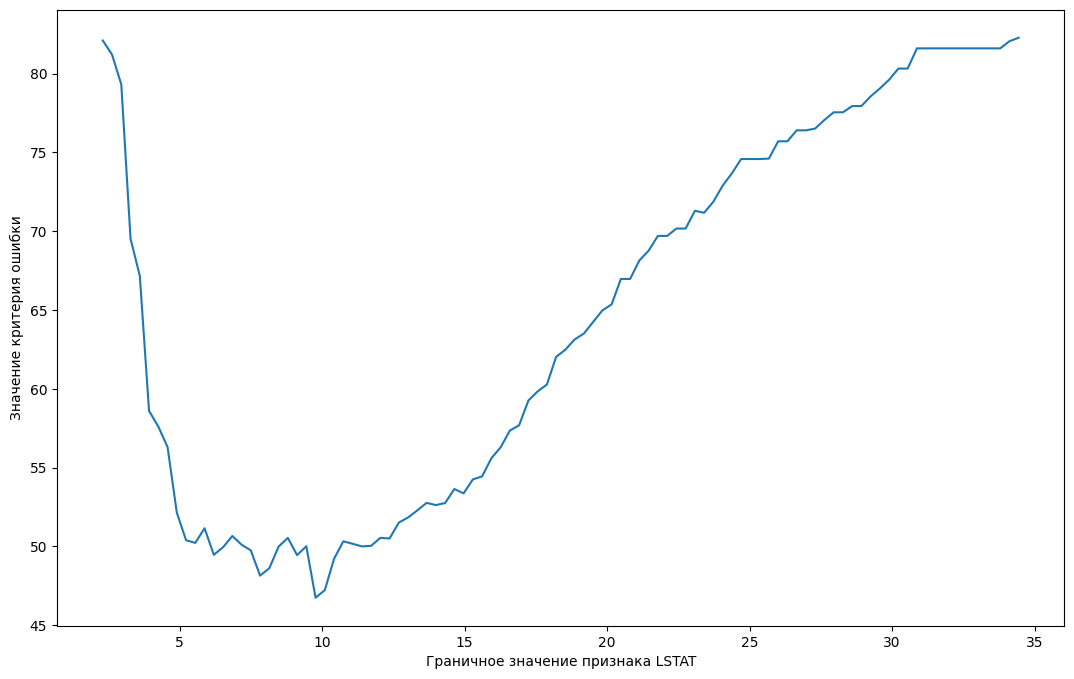

In [16]:
Q_best = -1
feature_best = ''
t_best = 0
ts_best = []
Qs_best = []
for feature in feature_names:
    t, Q, ts, Qs = get_optimal_split(X_train, feature)
    if Q_best == -1 or Q < Q_best:
        Q_best = Q
        feature_best = feature
        t_best = t
        ts_best = ts
        Qs_best = Qs

print(f'Best feature: {feature_best}')
print(f'Optimal bound: {t}')
print(f'Minimal error: {Q_best}')

fig, ax = plt.subplots(figsize=(13, 8))
ax.plot(ts_best, Qs_best)
_ = ax.set_xlabel(f"Граничное значение признака {feature}")
_ = ax.set_ylabel(f"Значение критерия ошибки")

*Комментарий:* здесь просто перебираем признаки и находим минимальную ошибку.

 **Задание 5 (2 балла)**: Изобразите разбиение визуально. Для этого постройте диаграмму рассеяния целевой переменной в зависимости от значения входного признака. Далее изобразите вертикальную линию, соответствующую порогу разбиения.

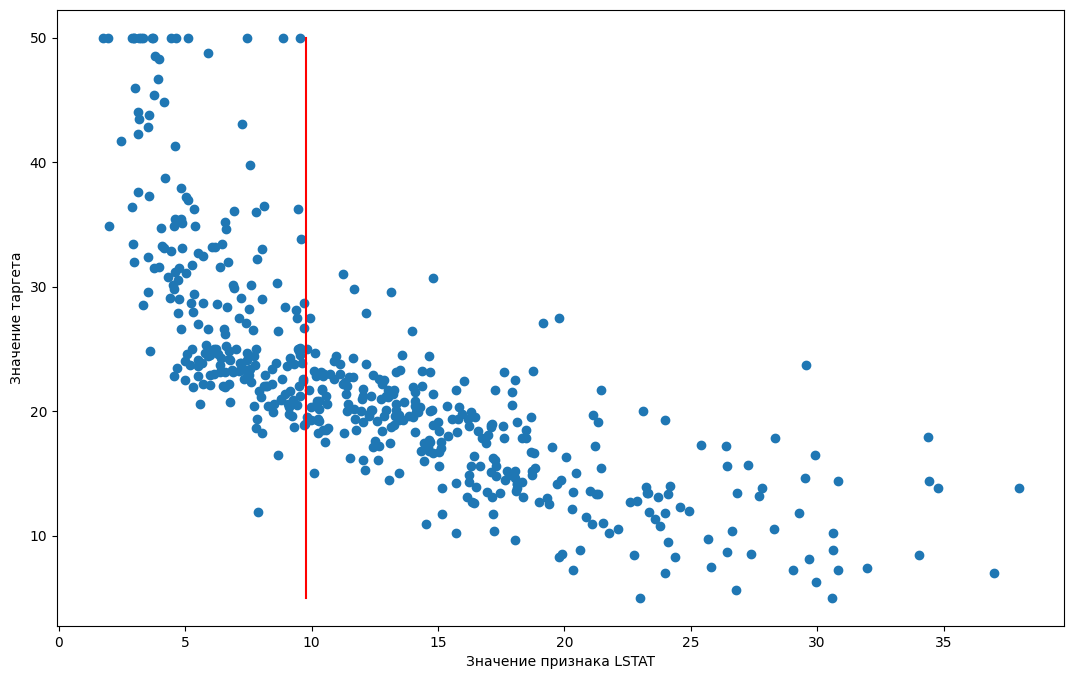

In [23]:
fig, ax = plt.subplots(figsize=(13, 8))
y = X.loc[:, 'target']
ax.scatter(X.loc[:, feature_best], y)
ax.plot(t_best * np.ones(100), np.linspace(np.min(y), np.max(y), 100), color='red')
_ = ax.set_xlabel(f"Значение признака {feature_best}")
_ = ax.set_ylabel(f"Значение таргета")

*Комментарий:* как видим, мы примерно разделили данные на область с большими значениями целевой переменной, где функция тренда резко убывает, и на область с низкими значениями, где тренд убывает медленнее.